In [4]:
# Cell 1: Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Forecasting models
from prophet import Prophet

# Date handling
from datetime import timedelta

# Settings
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')


Importing plotly failed. Interactive plots will not work.


In [3]:
!pip install prophet


   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   -- ------------------------------------- 0.8/12.1 MB 5.6 MB/s eta 0:00:03
   ------ --------------------------------- 2.1/12.1 MB 6.5 MB/s eta 0:00:02
   ------------ --------------------------- 3.7/12.1 MB 6.6 MB/s eta 0:00:02
   ---------------- ----------------------- 5.0/12.1 MB 6.7 MB/s eta 0:00:02
   --------------------- ------------------ 6.6/12.1 MB 6.7 MB/s eta 0:00:01
   ------------------------- -------------- 7.6/12.1 MB 6.4 MB/s eta 0:00:01
   --------------------------- ------------ 8.4/12.1 MB 6.1 MB/s eta 0:00:01
   ------------------------------- -------- 9.4/12.1 MB 6.0 MB/s eta 0:00:01
   --------------------------------- ------ 10.2/12.1 MB 5.8 MB/s eta 0:00:01
   ------------------------------------ --- 11.0/12.1 MB 5.5 MB/s eta 0:00:01
   -------------------------------------- - 11.8/12.1 MB 5.4 MB/s eta 0:00:01
   ---------------------------------------- 12.1/12.1 MB 5.2 MB/s eta 0:00:00
  


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
# Cell 2: Load Dataset

# Change the filename below to match your dataset
file_path = "E:\\transport-forecast-project\\data\\Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250603.csv"   # <-- update this if needed

df = pd.read_csv(file_path)

# Show first few rows
df.head()


,Date,Local Route,Light Rail,Peak Service,Rapid Route,School,Other
0,30/08/2024,16436,10705,225,19026,3925,59.0
1,15/09/2023,15499,10671,267,18421,4519,61.0
2,28/12/2021,1756,2352,0,3775,0,13.0
3,11/01/2023,10536,8347,223,14072,0,48.0
4,11/09/2021,820,612,0,1283,0,11.0


In [10]:
# Cell 3: Basic Exploration

print("Shape of dataset:", df.shape)
print("\nColumn Names:")
print(df.columns)

print("\nData Types:")
print(df.dtypes)

print("\nMissing Values:")
print(df.isnull().sum())

print("\nSummary Statistics:")
display(df.describe(include='all'))


Shape of dataset: (1918, 7)

Column Names:
Index(['Date', 'Local Route', 'Light Rail', 'Peak Service', 'Rapid Route',
       'School', 'Other'],
      dtype='object')

Data Types:
Date             object
Local Route       int64
Light Rail        int64
Peak Service      int64
Rapid Route       int64
School            int64
Other           float64
dtype: object

Missing Values:
Date             0
Local Route      0
Light Rail       0
Peak Service     0
Rapid Route      0
School           0
Other           20
dtype: int64

Summary Statistics:


,Date,Local Route,Light Rail,Peak Service,Rapid Route,School,Other
count,1918,1918.000000,1918.000000,1918.000000,1918.000000,1918.000000,1898.000000
unique,1918,NaN,NaN,NaN,NaN,NaN,NaN
top,30/08/2024,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,9891.395203,7195.446298,179.581335,12597.213243,2352.694995,43.390411
std,NaN,6120.715714,3345.616428,156.532738,6720.494557,2494.766306,41.746882
min,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,3044.500000,4463.500000,0.000000,6383.000000,0.000000,14.000000
50%,NaN,11417.000000,7507.000000,193.000000,13106.500000,567.500000,40.000000
75%,NaN,15517.500000,10008.250000,313.750000,17924.750000,4914.000000,68.000000


In [11]:
# Cell 4: Date Conversion & Sorting

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Sort by date (important for time series)
df = df.sort_values('Date')

# Reset index after sorting
df = df.reset_index(drop=True)

df.head()


,Date,Local Route,Light Rail,Peak Service,Rapid Route,School,Other
0,2019-07-01,15987,9962,407,21223,3715,NaN
1,2019-07-02,16895,10656,409,21715,3993,NaN
2,2019-07-03,16613,10658,427,22025,3638,NaN
3,2019-07-04,16604,10445,437,21868,3576,NaN
4,2019-07-05,16040,10532,400,20697,2856,NaN


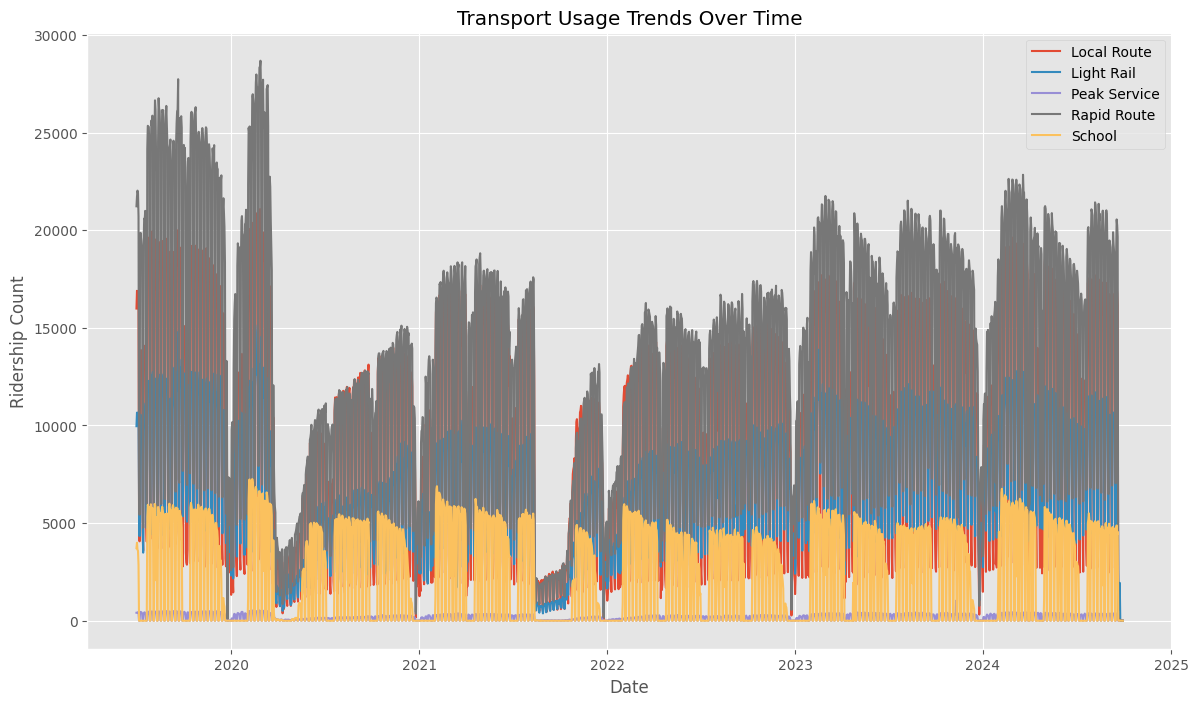

In [12]:
# Cell 5: Plot all route types over time

plt.figure(figsize=(14, 8))

plt.plot(df['Date'], df['Local Route'], label='Local Route')
plt.plot(df['Date'], df['Light Rail'], label='Light Rail')
plt.plot(df['Date'], df['Peak Service'], label='Peak Service')
plt.plot(df['Date'], df['Rapid Route'], label='Rapid Route')
plt.plot(df['Date'], df['School'], label='School')

plt.title("Transport Usage Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Ridership Count")
plt.legend()
plt.show()


In [13]:
# Cell 6: Function to train Prophet and forecast 7 days

def forecast_route(df, column_name, periods=7):
    """
    df: original dataframe with Date column
    column_name: route column to forecast (string)
    periods: how many future days to predict
    """
    
    # Prepare data for Prophet
    data = df[['Date', column_name]].rename(columns={'Date': 'ds', column_name: 'y'})
    
    # Initialize model
    model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
    
    # Fit model
    model.fit(data)
    
    # Future dataframe
    future = model.make_future_dataframe(periods=periods)
    
    # Forecast
    forecast = model.predict(future)
    
    # Plot
    model.plot(forecast)
    plt.title(f"Forecast for {column_name}")
    plt.show()
    
    return forecast.tail(periods)




====== Forecasting: Local Route ======



09:54:45 - cmdstanpy - INFO - Chain [1] start processing
09:54:46 - cmdstanpy - INFO - Chain [1] done processing


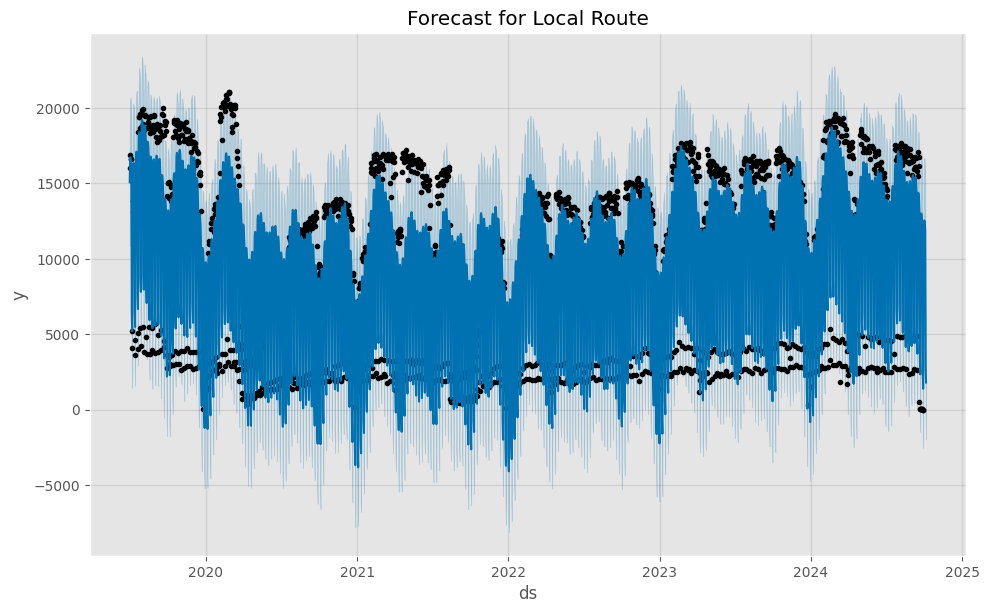

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1918,2024-09-30,13063.667945,6503.306491,14487.681385,13063.667945,13063.667945,-2483.615198,-2483.615198,-2483.615198,-1038.802748,-1038.802748,-1038.802748,1545.978393,1545.978393,1545.978393,-2990.790843,-2990.790843,-2990.790843,0.0,0.0,0.0,10580.052747
1919,2024-10-01,13065.831510,8460.436729,16532.926943,13065.831510,13065.831510,-689.929158,-689.929158,-689.929158,-1038.802748,-1038.802748,-1038.802748,3346.878374,3346.878374,3346.878374,-2998.004784,-2998.004784,-2998.004784,0.0,0.0,0.0,12375.902352
1920,2024-10-02,13067.995076,8853.635203,16683.277799,13067.995076,13067.995076,-526.999717,-526.999717,-526.999717,-1038.802748,-1038.802748,-1038.802748,3484.807878,3484.807878,3484.807878,-2973.004847,-2973.004847,-2973.004847,0.0,0.0,0.0,12540.995359
1921,2024-10-03,13070.158641,8476.639387,16426.288479,13070.158641,13070.158641,-678.903377,-678.903377,-678.903377,-1038.802748,-1038.802748,-1038.802748,3275.430698,3275.430698,3275.430698,-2915.531326,-2915.531326,-2915.531326,0.0,0.0,0.0,12391.255265
1922,2024-10-04,13072.322207,8264.435703,15718.024575,13072.322207,13072.322207,-1209.856591,-1209.856591,-1209.856591,-1038.802748,-1038.802748,-1038.802748,2654.865761,2654.865761,2654.865761,-2825.919604,-2825.919604,-2825.919604,0.0,0.0,0.0,11862.465616
1923,2024-10-05,13074.485772,-989.823484,6707.989803,13074.485772,13074.485772,-10359.343817,-10359.343817,-10359.343817,-1038.802748,-1038.802748,-1038.802748,-6615.442813,-6615.442813,-6615.442813,-2705.098256,-2705.098256,-2705.098256,0.0,0.0,0.0,2715.141955
1924,2024-10-06,13076.649338,-1988.910129,6061.042186,13076.649338,13076.649338,-11285.895455,-11285.895455,-11285.895455,-1038.802748,-1038.802748,-1038.802748,-7692.518292,-7692.518292,-7692.518292,-2554.574416,-2554.574416,-2554.574416,0.0,0.0,0.0,1790.753882


09:54:47 - cmdstanpy - INFO - Chain [1] start processing




====== Forecasting: Light Rail ======



09:54:48 - cmdstanpy - INFO - Chain [1] done processing


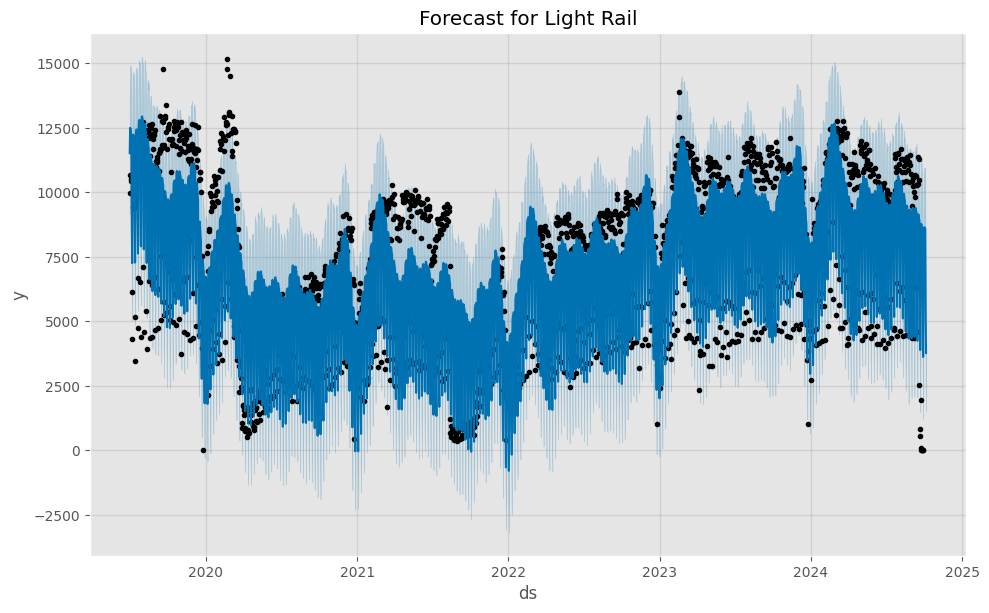

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1918,2024-09-30,7149.683760,5195.240811,9947.988909,7149.683760,7149.683760,405.918180,405.918180,405.918180,1350.96334,1350.96334,1350.96334,339.766817,339.766817,339.766817,-1284.811976,-1284.811976,-1284.811976,0.0,0.0,0.0,7555.601940
1919,2024-10-01,7148.137449,6221.079979,10940.049480,7148.137449,7148.137449,1461.382545,1461.382545,1461.382545,1350.96334,1350.96334,1350.96334,1392.073556,1392.073556,1392.073556,-1281.654350,-1281.654350,-1281.654350,0.0,0.0,0.0,8609.519994
1920,2024-10-02,7146.591138,6357.693763,10913.278300,7146.591138,7146.591138,1505.561351,1505.561351,1505.561351,1350.96334,1350.96334,1350.96334,1422.836876,1422.836876,1422.836876,-1268.238865,-1268.238865,-1268.238865,0.0,0.0,0.0,8652.152489
1921,2024-10-03,7145.044827,6223.555332,10859.940672,7145.044827,7145.044827,1426.447551,1426.447551,1426.447551,1350.96334,1350.96334,1350.96334,1319.807807,1319.807807,1319.807807,-1244.323596,-1244.323596,-1244.323596,0.0,0.0,0.0,8571.492378
1922,2024-10-04,7143.498517,6430.267061,10952.778192,7143.498517,7143.498517,1458.039140,1458.039140,1458.039140,1350.96334,1350.96334,1350.96334,1316.939900,1316.939900,1316.939900,-1209.864100,-1209.864100,-1209.864100,0.0,0.0,0.0,8601.537657
1923,2024-10-05,7141.952206,2659.770507,7306.110890,7141.952206,7141.952206,-2004.321622,-2004.321622,-2004.321622,1350.96334,1350.96334,1350.96334,-2190.266122,-2190.266122,-2190.266122,-1165.018840,-1165.018840,-1165.018840,0.0,0.0,0.0,5137.630583
1924,2024-10-06,7140.405895,1532.111367,6138.250867,7140.405895,7140.405895,-3360.345672,-3360.345672,-3360.345672,1350.96334,1350.96334,1350.96334,-3601.158834,-3601.158834,-3601.158834,-1110.150179,-1110.150179,-1110.150179,0.0,0.0,0.0,3780.060223




====== Forecasting: Peak Service ======



09:54:49 - cmdstanpy - INFO - Chain [1] start processing
09:54:50 - cmdstanpy - INFO - Chain [1] done processing


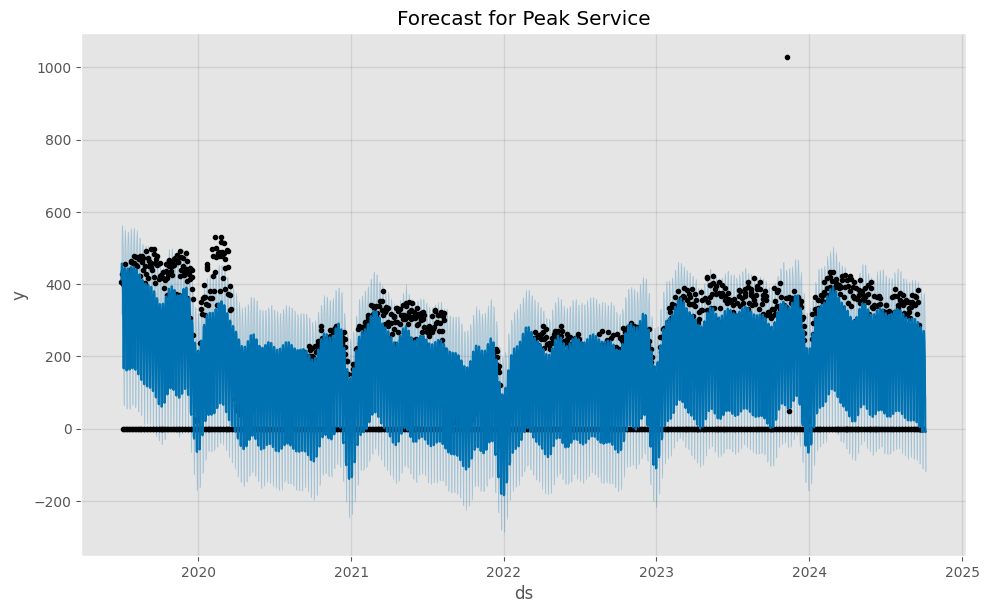

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1918,2024-09-30,255.782713,130.529009,339.272538,255.782713,255.782713,-31.058747,-31.058747,-31.058747,-40.959155,-40.959155,-40.959155,55.799752,55.799752,55.799752,-45.899343,-45.899343,-45.899343,0.0,0.0,0.0,224.723966
1919,2024-10-01,255.749030,171.799891,375.216041,255.749030,255.749030,14.424303,14.424303,14.424303,-40.959155,-40.959155,-40.959155,101.950336,101.950336,101.950336,-46.566878,-46.566878,-46.566878,0.0,0.0,0.0,270.173334
1920,2024-10-02,255.715348,169.237567,370.671145,255.715348,255.715348,14.236356,14.236356,14.236356,-40.959155,-40.959155,-40.959155,102.068059,102.068059,102.068059,-46.872548,-46.872548,-46.872548,0.0,0.0,0.0,269.951704
1921,2024-10-03,255.681665,144.464108,346.381825,255.681665,255.681665,-12.271823,-12.271823,-12.271823,-40.959155,-40.959155,-40.959155,75.478029,75.478029,75.478029,-46.790697,-46.790697,-46.790697,0.0,0.0,0.0,243.409842
1922,2024-10-04,255.647983,84.508233,288.851637,255.647983,255.647983,-63.887778,-63.887778,-63.887778,-40.959155,-40.959155,-40.959155,23.373264,23.373264,23.373264,-46.301887,-46.301887,-46.301887,0.0,0.0,0.0,191.760204
1923,2024-10-05,255.614300,-116.798442,92.736891,255.614300,255.614300,-265.735930,-265.735930,-265.735930,-40.959155,-40.959155,-40.959155,-179.383202,-179.383202,-179.383202,-45.393573,-45.393573,-45.393573,0.0,0.0,0.0,-10.121629
1924,2024-10-06,255.580618,-118.004123,90.135263,255.580618,255.580618,-264.306023,-264.306023,-264.306023,-40.959155,-40.959155,-40.959155,-179.286237,-179.286237,-179.286237,-44.060631,-44.060631,-44.060631,0.0,0.0,0.0,-8.725405




====== Forecasting: Rapid Route ======



09:54:51 - cmdstanpy - INFO - Chain [1] start processing
09:54:51 - cmdstanpy - INFO - Chain [1] done processing


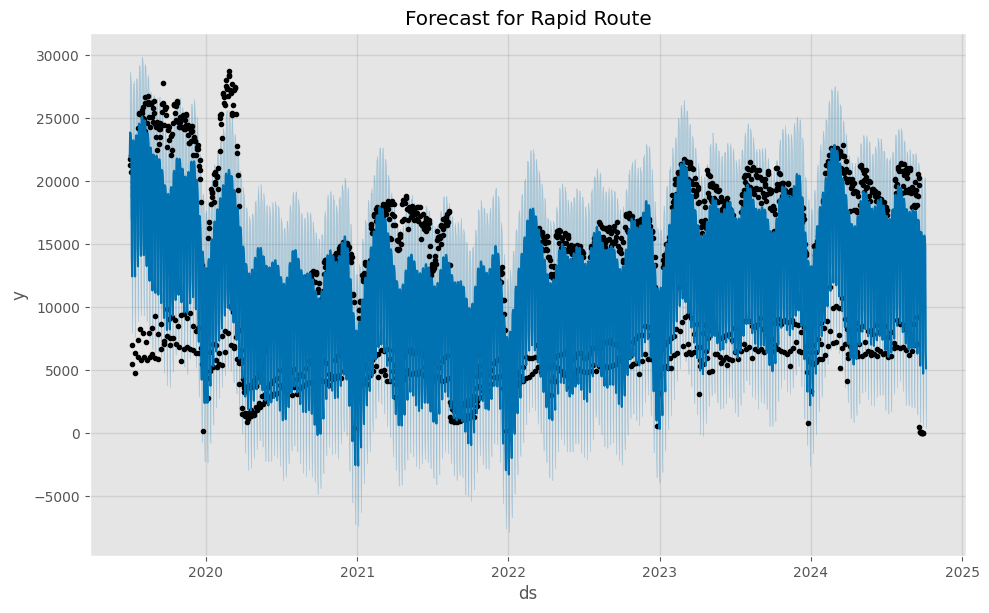

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1918,2024-09-30,14571.751695,8668.458379,17768.344698,14571.751695,14571.751695,-1120.850091,-1120.850091,-1120.850091,210.613503,210.613503,210.613503,1248.113405,1248.113405,1248.113405,-2579.577000,-2579.577000,-2579.577000,0.0,0.0,0.0,13450.901603
1919,2024-10-01,14571.198785,10894.280424,19781.597059,14571.198785,14571.198785,985.952848,985.952848,985.952848,210.613503,210.613503,210.613503,3343.600122,3343.600122,3343.600122,-2568.260777,-2568.260777,-2568.260777,0.0,0.0,0.0,15557.151633
1920,2024-10-02,14570.645875,11273.808473,20207.515825,14570.645875,14570.645875,1072.641924,1072.641924,1072.641924,210.613503,210.613503,210.613503,3394.049414,3394.049414,3394.049414,-2532.020994,-2532.020994,-2532.020994,0.0,0.0,0.0,15643.287799
1921,2024-10-03,14570.092965,11465.176018,20251.932418,14570.092965,14570.092965,882.934743,882.934743,882.934743,210.613503,210.613503,210.613503,3142.937850,3142.937850,3142.937850,-2470.616610,-2470.616610,-2470.616610,0.0,0.0,0.0,15453.027709
1922,2024-10-04,14569.540055,10170.593574,19406.359547,14569.540055,14569.540055,175.876308,175.876308,175.876308,210.613503,210.613503,210.613503,2349.538139,2349.538139,2349.538139,-2384.275334,-2384.275334,-2384.275334,0.0,0.0,0.0,14745.416364
1923,2024-10-05,14568.987145,2213.882395,11416.513809,14568.987145,14568.987145,-8010.640857,-8010.640857,-8010.640857,210.613503,210.613503,210.613503,-5947.557379,-5947.557379,-5947.557379,-2273.696981,-2273.696981,-2273.696981,0.0,0.0,0.0,6558.346289
1924,2024-10-06,14568.434236,376.526996,9623.901563,14568.434236,14568.434236,-9460.114672,-9460.114672,-9460.114672,210.613503,210.613503,210.613503,-7530.681551,-7530.681551,-7530.681551,-2140.046625,-2140.046625,-2140.046625,0.0,0.0,0.0,5108.319563




====== Forecasting: School ======



09:54:52 - cmdstanpy - INFO - Chain [1] start processing
09:54:53 - cmdstanpy - INFO - Chain [1] done processing


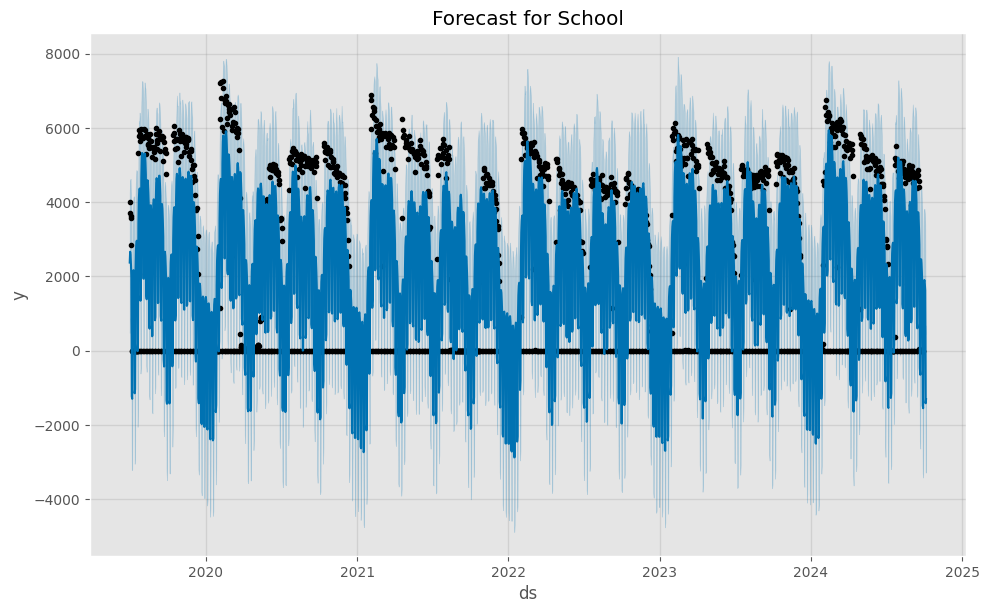

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1918,2024-09-30,3342.994496,-468.659143,3355.894319,3342.994496,3342.994496,-1924.626292,-1924.626292,-1924.626292,-743.434824,-743.434824,-743.434824,659.879469,659.879469,659.879469,-1841.070937,-1841.070937,-1841.070937,0.0,0.0,0.0,1418.368204
1919,2024-10-01,3343.481499,-48.311978,3805.188443,3343.481499,3343.481499,-1501.138038,-1501.138038,-1501.138038,-743.434824,-743.434824,-743.434824,1100.456774,1100.456774,1100.456774,-1858.159988,-1858.159988,-1858.159988,0.0,0.0,0.0,1842.343461
1920,2024-10-02,3343.968502,-17.277221,3818.053492,3343.968502,3343.968502,-1441.239705,-1441.239705,-1441.239705,-743.434824,-743.434824,-743.434824,1151.057771,1151.057771,1151.057771,-1848.862652,-1848.862652,-1848.862652,0.0,0.0,0.0,1902.728797
1921,2024-10-03,3344.455505,-119.945896,3695.462499,3344.455505,3344.455505,-1539.473557,-1539.473557,-1539.473557,-743.434824,-743.434824,-743.434824,1017.362672,1017.362672,1017.362672,-1813.401404,-1813.401404,-1813.401404,0.0,0.0,0.0,1804.981948
1922,2024-10-04,3344.942508,-338.705764,3403.475892,3344.942508,3344.942508,-1722.230303,-1722.230303,-1722.230303,-743.434824,-743.434824,-743.434824,773.720143,773.720143,773.720143,-1752.515622,-1752.515622,-1752.515622,0.0,0.0,0.0,1622.712205
1923,2024-10-05,3345.429511,-3276.040554,457.702308,3345.429511,3345.429511,-4762.259869,-4762.259869,-4762.259869,-743.434824,-743.434824,-743.434824,-2351.384358,-2351.384358,-2351.384358,-1667.440687,-1667.440687,-1667.440687,0.0,0.0,0.0,-1416.830359
1924,2024-10-06,3345.916514,-3283.797362,677.172938,3345.916514,3345.916514,-4654.402880,-4654.402880,-4654.402880,-743.434824,-743.434824,-743.434824,-2351.092471,-2351.092471,-2351.092471,-1559.875585,-1559.875585,-1559.875585,0.0,0.0,0.0,-1308.486367


In [14]:
# Cell 7: Forecasting each route

routes = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']

forecast_results = {}

for route in routes:
    print(f"\n\n====== Forecasting: {route} ======\n")
    result = forecast_route(df, route, periods=7)
    forecast_results[route] = result
    display(result)


In [15]:
# Cell 8: Save forecast results into CSV files

import os

# Create results folder if not exists
os.makedirs("../results", exist_ok=True)

for route, result in forecast_results.items():
    filename = f"../results/forecast_{route.replace(' ', '_')}.csv"
    result.to_csv(filename, index=False)
    print(f"Saved: {filename}")


Saved: ../results/forecast_Local_Route.csv
Saved: ../results/forecast_Light_Rail.csv
Saved: ../results/forecast_Peak_Service.csv
Saved: ../results/forecast_Rapid_Route.csv
Saved: ../results/forecast_School.csv


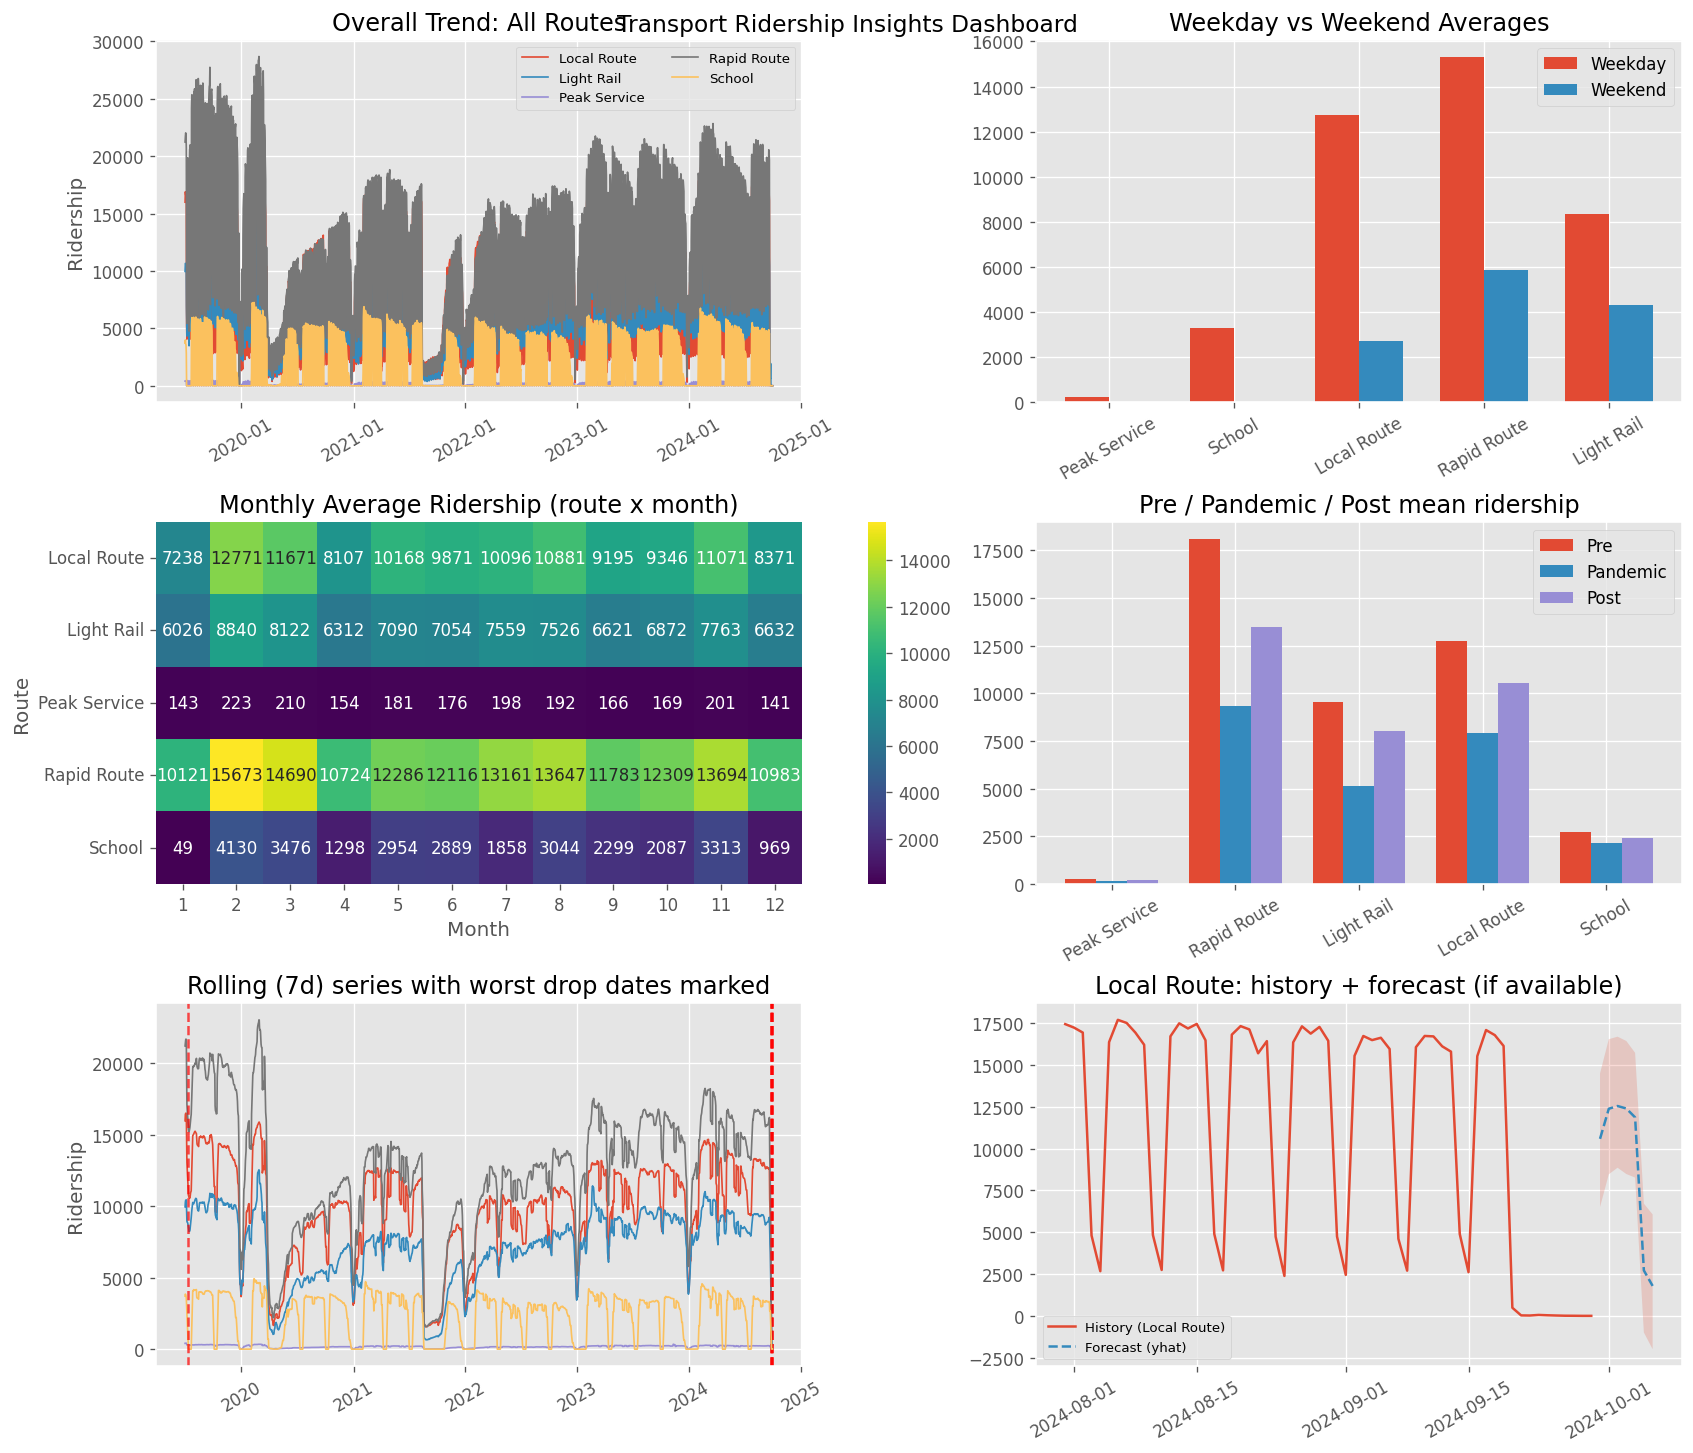

Saved dashboard to: ../results/insights_images\dashboard_insights.png


In [17]:
# --- Cell A: Dashboard - prepare data & create combined visualization ---
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter

plt.rcParams['figure.dpi'] = 120
out_img_folder = "../results/insights_images"
os.makedirs(out_img_folder, exist_ok=True)
os.makedirs("../results/insights", exist_ok=True)
os.makedirs("../reports", exist_ok=True)

# Load df if not in memory
if 'df' not in globals():
    fp = "../data/transport.csv"
    if os.path.exists(fp):
        df = pd.read_csv(fp)
    else:
        raise RuntimeError("Dataframe 'df' not found and ../data/transport.csv missing. Run earlier cells first.")

df['Date'] = pd.to_datetime(df['Date'])
routes = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']

# Weekday vs Weekend
df['weekday'] = df['Date'].dt.weekday
df['is_weekend'] = df['weekday'].isin([5,6])
rows = []
for r in routes:
    avg_weekday = df.loc[~df['is_weekend'], r].mean()
    avg_weekend = df.loc[df['is_weekend'], r].mean()
    pct_diff = (avg_weekday - avg_weekend) / (avg_weekday if avg_weekday != 0 else 1) * 100
    rows.append({'route': r, 'avg_weekday': float(avg_weekday), 'avg_weekend': float(avg_weekend),
                 'weekday_vs_weekend_pct_diff': float(pct_diff)})
weekday_df = pd.DataFrame(rows).sort_values('weekday_vs_weekend_pct_diff', ascending=False)
weekday_df.to_csv("../results/insights/weekday_vs_weekend_summary.csv", index=False)

# Monthly averages
df['month'] = df['Date'].dt.month
monthly = df.groupby('month')[routes].mean().reset_index().set_index('month')
monthly.to_csv("../results/insights/monthly_avg_by_route.csv")

# Pandemic summary
pre_end = pd.to_datetime("2020-02-29")
pandemic_start = pd.to_datetime("2020-03-01")
pandemic_end = pd.to_datetime("2021-12-31")
post_start = pd.to_datetime("2022-01-01")
rows = []
for r in routes:
    pre_mean = df.loc[df['Date'] <= pre_end, r].mean()
    pan_mean = df.loc[(df['Date'] >= pandemic_start) & (df['Date'] <= pandemic_end), r].mean()
    post_mean = df.loc[df['Date'] >= post_start, r].mean()
    drop_pct = (pre_mean - pan_mean) / (pre_mean if pre_mean != 0 else 1) * 100
    recovery_pct = (post_mean - pan_mean) / (pan_mean if pan_mean != 0 else 1) * 100
    rows.append({'route': r, 'pre_mean': float(pre_mean if not pd.isna(pre_mean) else 0),
                 'pandemic_mean': float(pan_mean if not pd.isna(pan_mean) else 0),
                 'post_mean': float(post_mean if not pd.isna(post_mean) else 0),
                 'drop_pct_from_pre_to_pandemic': float(drop_pct),
                 'recovery_pct_from_pandemic_to_post': float(recovery_pct)})
pandemic_df = pd.DataFrame(rows).sort_values('drop_pct_from_pre_to_pandemic', ascending=False)
pandemic_df.to_csv("../results/insights/pandemic_impact_summary.csv", index=False)

# Drops detection
window = 7
drops = []
for r in routes:
    series = df.set_index('Date')[r].astype(float)
    rolling = series.rolling(window, center=True, min_periods=1).mean()
    pct_change = rolling.pct_change().fillna(0)
    worst = pct_change.nsmallest(5)
    for idx, val in worst.items():
        drops.append({'route': r, 'date_of_drop': idx.strftime('%Y-%m-%d'),
                      'pct_change_on_drop': float(val),
                      'rolling_value_before': float(rolling.shift(1).loc[idx]) if idx in rolling.index else None,
                      'rolling_value_at': float(rolling.loc[idx])})
drops_df = pd.DataFrame(drops).sort_values(['route', 'pct_change_on_drop'])
drops_df.to_csv("../results/insights/largest_drops_summary.csv", index=False)

# Plot dashboard (3x2)
fig = plt.figure(constrained_layout=True, figsize=(14,12))
gs = fig.add_gridspec(3, 2)

ax0 = fig.add_subplot(gs[0, 0])
for r in routes:
    ax0.plot(df['Date'], df[r], label=r, linewidth=1)
ax0.set_title("Overall Trend: All Routes")
ax0.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
ax0.tick_params(axis='x', rotation=30)
ax0.set_ylabel("Ridership")
ax0.legend(fontsize=8, ncol=2)

ax1 = fig.add_subplot(gs[0, 1])
ind = np.arange(len(weekday_df))
width = 0.35
ax1.bar(ind - width/2, weekday_df['avg_weekday'], width, label='Weekday')
ax1.bar(ind + width/2, weekday_df['avg_weekend'], width, label='Weekend')
ax1.set_xticks(ind)
ax1.set_xticklabels(weekday_df['route'], rotation=30)
ax1.set_title("Weekday vs Weekend Averages")
ax1.legend()

ax2 = fig.add_subplot(gs[1, 0])
sns.heatmap(monthly.T, annot=True, fmt=".0f", cmap='viridis', ax=ax2)
ax2.set_title("Monthly Average Ridership (route x month)")
ax2.set_xlabel("Month")
ax2.set_ylabel("Route")

ax3 = fig.add_subplot(gs[1, 1])
x = np.arange(len(pandemic_df))
bar_w = 0.25
ax3.bar(x - bar_w, pandemic_df['pre_mean'], width=bar_w, label='Pre')
ax3.bar(x, pandemic_df['pandemic_mean'], width=bar_w, label='Pandemic')
ax3.bar(x + bar_w, pandemic_df['post_mean'], width=bar_w, label='Post')
ax3.set_xticks(x)
ax3.set_xticklabels(pandemic_df['route'], rotation=30)
ax3.set_title("Pre / Pandemic / Post mean ridership")
ax3.legend()

ax4 = fig.add_subplot(gs[2, 0])
for r in routes:
    ser = df.set_index('Date')[r].rolling(window=7, min_periods=1).mean()
    ax4.plot(ser.index, ser.values, label=r, linewidth=1)
    sub = drops_df[drops_df['route'] == r].sort_values('pct_change_on_drop').head(1)
    if not sub.empty:
        d = pd.to_datetime(sub['date_of_drop'].values[0])
        if d in ser.index:
            ax4.axvline(d, color='red', linestyle='--', alpha=0.7)
ax4.set_title("Rolling (7d) series with worst drop dates marked")
ax4.set_ylabel("Ridership")
ax4.tick_params(axis='x', rotation=30)

ax5 = fig.add_subplot(gs[2, 1])
forecast_loaded = False
try:
    fpath = "../results/forecast_Local_Route.csv"
    if os.path.exists(fpath):
        fdf = pd.read_csv(fpath)
        fdf['ds'] = pd.to_datetime(fdf['ds'])
        recent = df[df['Date'] >= (df['Date'].max() - pd.Timedelta(days=60))]
        ax5.plot(recent['Date'], recent['Local Route'], label='History (Local Route)')
        ax5.plot(fdf['ds'], fdf['yhat'], label='Forecast (yhat)', linestyle='--')
        ax5.fill_between(fdf['ds'], fdf['yhat_lower'], fdf['yhat_upper'], alpha=0.2)
        ax5.set_title("Local Route: history + forecast (if available)")
        forecast_loaded = True
except Exception:
    forecast_loaded = False

if not forecast_loaded:
    ax5.text(0.5, 0.5, "Forecast CSV not found\n(../results/forecast_Local_Route.csv)", ha='center', va='center')
    ax5.set_title("Forecast placeholder")
ax5.tick_params(axis='x', rotation=30)
ax5.legend(fontsize=8)

outpath = os.path.join(out_img_folder, "dashboard_insights.png")
fig.suptitle("Transport Ridership Insights Dashboard", fontsize=14, y=0.995)
fig.savefig(outpath, bbox_inches='tight')
plt.show()
print("Saved dashboard to:", outpath)


In [18]:
# --- Cell B: Write insight_report.md with embedded dashboard image ---
import os
md_path = "../reports/insight_report.md"
os.makedirs("../reports", exist_ok=True)

md = f"""# Insight Report — Transport Ridership Forecasting

This report contains programmatic insights and visualizations generated from the dataset.

## 1. Dashboard Overview
![Dashboard](../results/insights_images/dashboard_insights.png)

## 2. Weekday vs Weekend summary
See the chart in the dashboard. Detailed CSV: `../results/insights/weekday_vs_weekend_summary.csv`

## 3. Monthly seasonality (heatmap)
See the dashboard heatmap. CSV: `../results/insights/monthly_avg_by_route.csv`

## 4. Pandemic impact
Pre / Pandemic / Post means and changes saved at:
`../results/insights/pandemic_impact_summary.csv`

## 5. Largest drops / Anomalies
Top detected drops saved at:
`../results/insights/largest_drops_summary.csv`

## 6. Quick recommendations (auto-generated)
- Use weekday-vs-weekend demand to size service frequency on weekdays.  
- Investigate the largest drop dates for operational causes (strikes, weather, lockdowns).  
- Add holiday calendars to the forecasting model to improve accuracy.  
- Consider focused monitoring for School route during term transitions.
"""

with open(md_path, "w") as f:
    f.write(md)

print("Saved insight report to:", md_path)


Saved insight report to: ../reports/insight_report.md


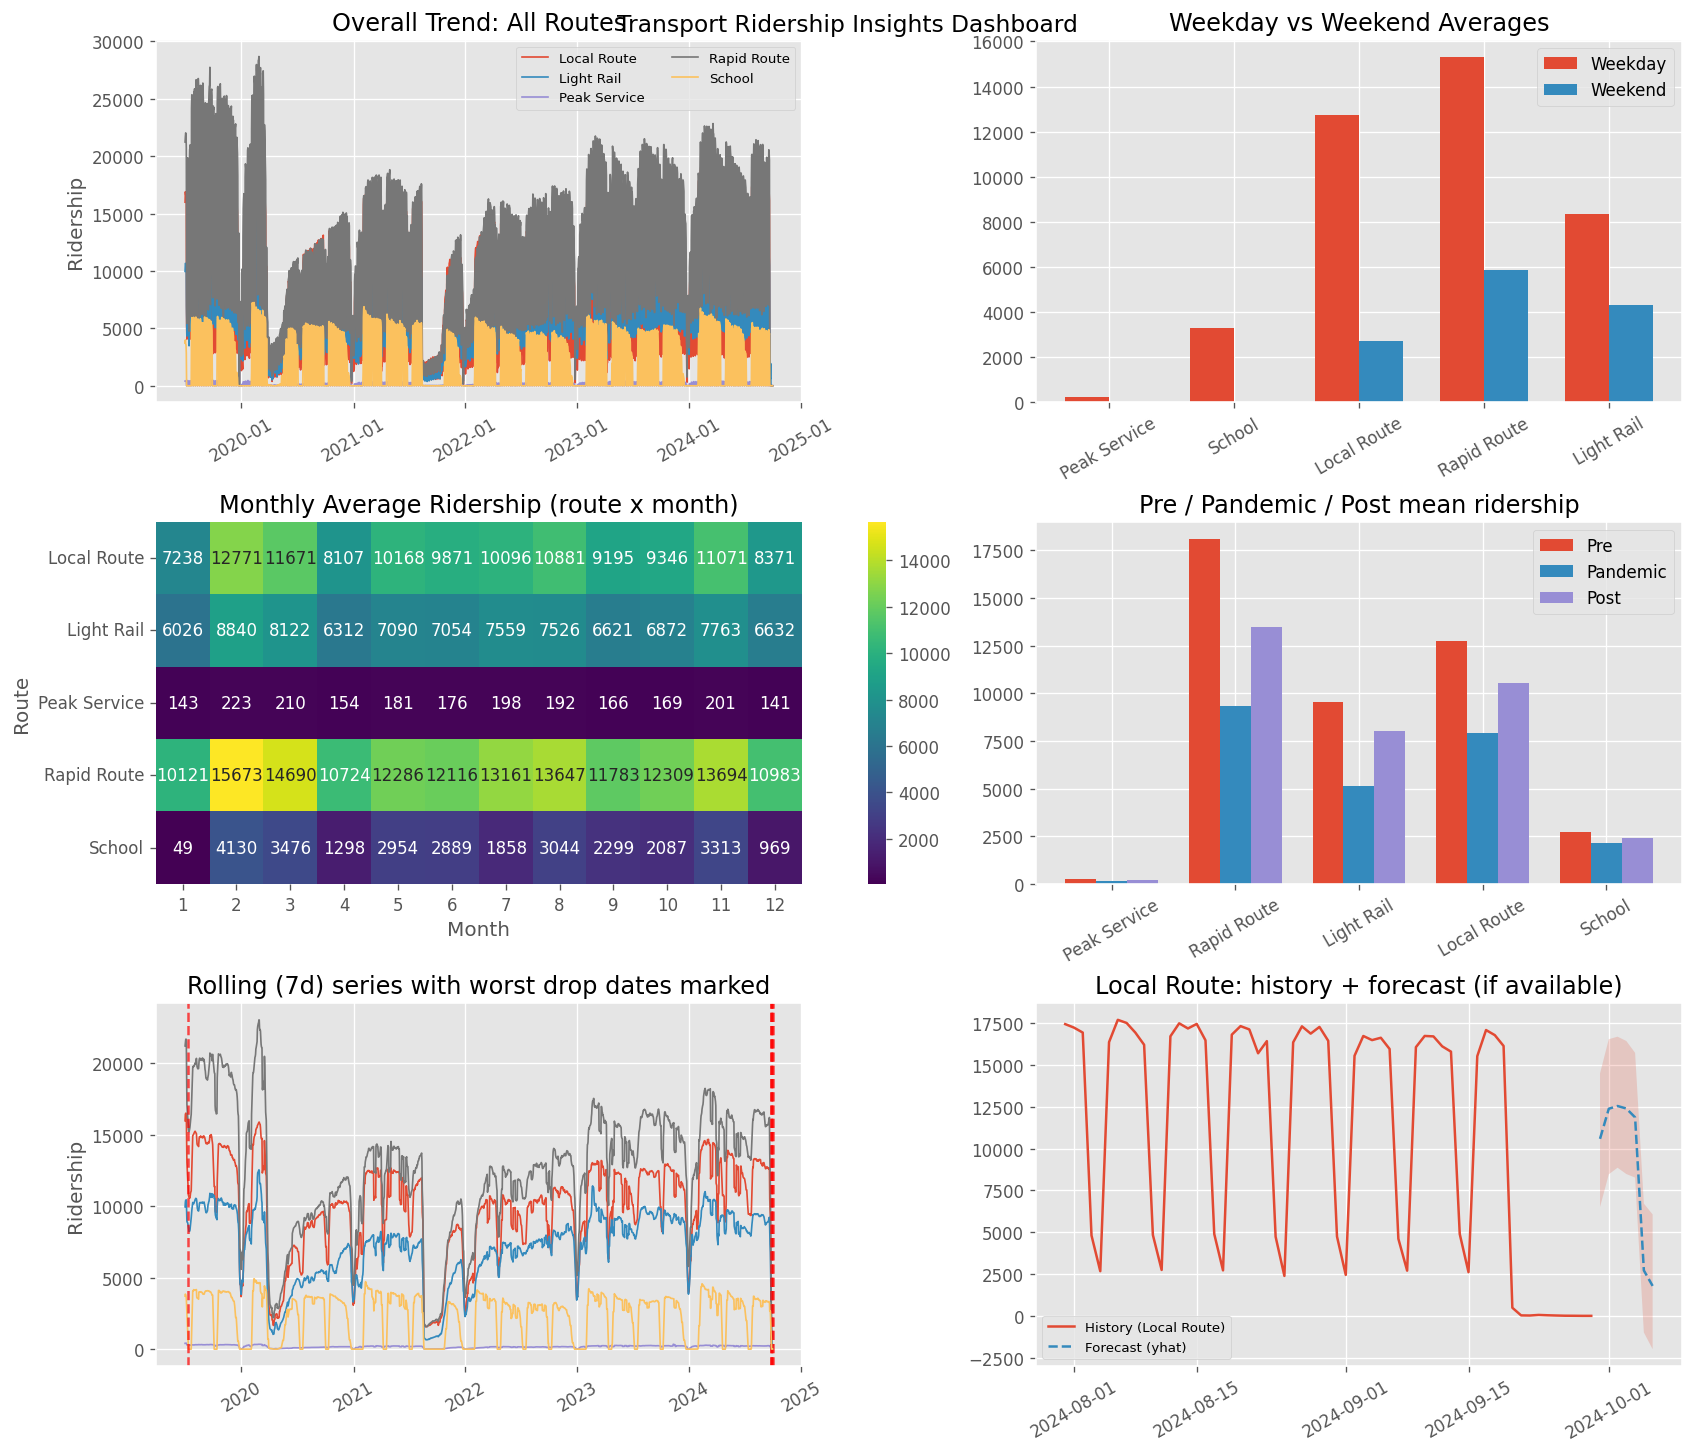

Missing: overall_trend_all_routes.png
Missing: weekday_vs_weekend.png
Missing: monthly_heatmap.png
Missing: drops_annotation.png


In [19]:
# --- Cell C: Display dashboard and saved images for quick verification ---
from IPython.display import Image, display
display(Image(filename="../results/insights_images/dashboard_insights.png"))

for fn in ["overall_trend_all_routes.png", "weekday_vs_weekend.png", "monthly_heatmap.png", "drops_annotation.png"]:
    p = f"../results/insights_images/{fn}"
    if os.path.exists(p):
        print("Showing:", fn)
        display(Image(filename=p))
    else:
        print("Missing:", fn)
